# Readme

Folder Structure

  /project_folder
    IS5126_Guided_Project.ipynb
    /data
      player_salaries.pkl
      player_info.pkl
      player_statistics.pkl
      team_info.pkl
      team_statistics.pkl

# Import Libraries

In [8]:
import os
import argparse
import pickle 


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import statsmodels.api as sm
import statsmodels.stats.api as sms

from linearmodels import PanelOLS
from linearmodels import RandomEffects
from scipy import stats

In [9]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Define Filepaths

Folder Paths

In [10]:
MAIN_FOLDER = r"./"
DATA_FOLDER = os.path.join(MAIN_FOLDER, "data")

File Paths

In [19]:
SALARY_FILE = os.path.join(DATA_FOLDER, "player_salaries_all_combined.csv")
PLAYER_INFO_FILE = os.path.join(DATA_FOLDER, "season_per_game.csv")
PLAYER_STATS_FILE = os.path.join(DATA_FOLDER, "season_per_game.csv")
TEAM_INFO_FILE = os.path.join(DATA_FOLDER, "team_info.csv")
TEAM_STATS_FILE = os.path.join(DATA_FOLDER, "team_season_per_game.csv")

# Read Data

In [20]:
df_salary = pd.read_csv (SALARY_FILE, encoding='latin1')
df_player_info = pd.read_csv (PLAYER_INFO_FILE, encoding='latin1')
df_player_stats = pd.read_csv (PLAYER_STATS_FILE, encoding='latin1')
df_team_info = pd.read_csv (TEAM_INFO_FILE, encoding='latin1')
df_team_stats = pd.read_csv (TEAM_STATS_FILE, encoding='latin1')

# Data Samples

In [22]:
df_salary.head(1)

,SN,player,season,team,salary
0,0,Ãlex Abrines,2016-17,Oklahoma City Thunder,5994764


In [23]:
df_player_info.head(1)

,ï»¿SN,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season
0,0,Arron Afflalo,SG,24,DEN,82,75,27.1,3.3,7.1,...,0.7,2.4,3.1,1.7,0.6,0.4,0.9,2.7,8.8,2009-10


In [24]:
df_player_stats.head(1)

,ï»¿SN,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season
0,0,Arron Afflalo,SG,24,DEN,82,75,27.1,3.3,7.1,...,0.7,2.4,3.1,1.7,0.6,0.4,0.9,2.7,8.8,2009-10


In [25]:
df_team_info.head(1)

,ï»¿SN,name,location,team_names,seasons,record,playoff_appearances,championships
0,0,Philadelphia 76ers,Pennsylvania,"Philadelphia 76ers, Syracuse Nationals",73,0.519,51,3


In [10]:
df_team_stats.head(1)

,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season
0,Phoenix Suns,82,240.6,40.7,82.8,.492,8.9,21.6,.412,31.8,...,11.1,31.9,43.0,23.3,5.8,5.1,14.8,20.9,110.2,2009-10


# General Helper Functions

In [11]:
def _lowercase_colnames(df):
    df.columns = [col.lower() for col in df.columns]
    return df

# Part B

### Question 1a

Convert all columns to lower case for standardization

In [12]:
df_salary = _lowercase_colnames(df=df_salary)
df_player_stats = _lowercase_colnames(df=df_player_stats)
df_team_info = _lowercase_colnames(df=df_team_info)
df_team_stats = _lowercase_colnames(df=df_team_stats)

Standardize column names for joining

In [13]:
# For df_salary
salary_rename = {"team": "team_name"}

# For df_player_info
player_info_rename = {"name": "player"}

# For df_team_stats
team_stats_rename = {col: "team_"+col for col in df_team_stats.columns}
team_stats_rename["team"] = "team_name"
del team_stats_rename["season"]

# For df_team_info
team_info_rename = {col: "team_"+col for col in df_team_info.columns}
team_info_rename["team_names"] = "full_team_name"
team_info_rename["seasons"] = "team_total_seasons"

Rename column names

In [14]:
df_salary = df_salary.rename(columns=salary_rename)
df_player_info = df_player_info.rename(columns=player_info_rename)
df_team_stats = df_team_stats.rename(columns=team_stats_rename)
df_team_info = df_team_info.rename(columns=team_info_rename)

Remove asterisks from player name

In [15]:
df_salary["player"] = df_salary["player"].str.replace("*", "", regex=False)
df_player_stats["player"] = df_player_stats["player"].str.replace("*", "", regex=False)

Merge salary and player statistics (outer join)

In [16]:
df = df_salary.merge(df_player_stats,
                     how="outer",
                     on=["player", "season"])

Filter players active between 2009/2010 - 2019/2020 seasons

In [17]:
START_SEASON = 2009
END_SEASON = 2019
df["season_year"] = df["season"].str.split("-").str[0].astype(int)
df_active = df.loc[(df["season_year"]>=START_SEASON)
                    &(df["season_year"]<=END_SEASON), :]
df_active = pd.DataFrame(df_active.loc[:, "player"])

Get unique active players

In [18]:
df_active = df_active.drop_duplicates(subset=["player"], keep="first")

Merge with main df to get statistics of active players only

In [19]:
df = df.merge(df_active,
              how="inner",
              on=["player"])

Convert player height and weight

In [20]:
df_height_info = df_player_info["height"].str.split("-")
df_player_info["height"] = df_height_info.str[0].astype(int) * 30.48 + df_height_info.str[1].astype(int) * 2.54

df_weight_info = df_player_info["weight"].str.split("lb").str[0].astype(int)
df_player_info["weight"] = df_weight_info * 0.453592

Remove birthday

In [21]:
df_player_info = df_player_info.drop(columns=["birthday"])

Merge with main df to get height and weight of players

In [22]:
df = df.merge(df_player_info,
              how="left",
              on=["player"])

Get experience for each player

In [23]:
df_exp = (df.groupby("player")
            .agg({"season_year": [np.min, np.max]})
            .reset_index(drop=False))
df_exp.columns = ["player", "start_year", "latest_year"]
df_exp["experience"] = df_exp["latest_year"] - df_exp["start_year"]

Merge with main df to get experience of active players only

In [24]:
df = df.merge(df_exp,
              how="inner",
              on=["player"])

Get total salary for each player

In [25]:
df_total_salary = df_salary.groupby("player").agg({"salary": "sum"})
df_total_salary = df_total_salary.reset_index(drop=False)
df_total_salary.columns = ["player", "total_salary"]

Merge with main df to get total salary of active players only

In [26]:
df = df.merge(df_total_salary,
              how="left",
              on=["player"])

Get YTD experience

In [27]:
df["experience_YTD"] = df["season_year"] - df["start_year"]

Rename old team names with new

In [28]:
df["team_name"] = df["team_name"].str.replace("New Orleans Hornets", "New Orleans Pelicans", regex=False)
df["team_name"] = df["team_name"].str.replace("Charlotte Bobcats", "Charlotte Hornets", regex=False)
df["team_name"] = df["team_name"].str.replace("New Jersey Nets", "Brooklyn Nets", regex=False)

df_team_stats["team_name"] = df_team_stats["team_name"].str.replace("New Orleans Hornets", "New Orleans Pelicans", regex=False)
df_team_stats["team_name"] = df_team_stats["team_name"].str.replace("Charlotte Bobcats", "Charlotte Hornets", regex=False)
df_team_stats["team_name"] = df_team_stats["team_name"].str.replace("New Jersey Nets", "Brooklyn Nets", regex=False)

Merge team info and team stats

In [29]:
df_team_info = df_team_info.merge(df_team_stats,
                                  how="inner",
                                  on=["team_name"])

Merge with main df to get team info

In [30]:
df = df.merge(df_team_info,
              how="inner",
              on=["team_name", "season"])

Drop unmatched rows with partial data

In [31]:
df = df.dropna(how="any")

Convert missing values "<s+>" to None

In [32]:
df = df.replace(r"^\s*$", np.nan, regex=True)

Identify columns with missing values

In [33]:
missing_cols = df.columns[df.isnull().any()]
print("Columns with missing values: {}".format(missing_cols))

Columns with missing values: Index(['fg%', '3p%', '2p%', 'efg%', 'ft%'], dtype='object')


Replace missing values with 0 since all of them at percentages

In [34]:
df = df.fillna(0)

Convert numeric columns to numeric (brute force)

In [35]:
for col in list(df.columns):
    try:
        df[col] = df[col].astype(float)
    except ValueError:
        continue

Number of teams playing for per season

In [56]:
df_num_teams = (df.groupby(["player", "season"])
                  .agg({"team_name": pd.Series.nunique})
                  .reset_index(drop=False)
                  .rename(columns={"team_name": "team_count"}))
df = df.merge(df_num_teams,
              how="inner",
              on=["player", "season"]).reset_index(drop=True)

Get YTD age

In [59]:
df["age_YTD"] = df["age"] - (MOST_CURRENT_SEASON - df["season_year"])

Reset Index

In [36]:
df = df.reset_index(drop=True)

### Question 2a

Define most current season 

In [37]:
MOST_CURRENT_SEASON = 2019

Subset data to retrive most current season 

In [38]:
df_current = df.loc[df["season_year"]==MOST_CURRENT_SEASON, :]

Get number of active players

In [39]:
active_players = df_current["player"].unique()
print("Number of active players: {}".format(len(active_players)))

Number of active players: 449


### Question 2b

Get number of players in each position

In [40]:
position_brkdown = (df_current.groupby(["pos"])
                              .agg({"player": pd.Series.nunique})
                              .reset_index(drop=False))
print("Positions: ")
position_brkdown

Positions: 


,pos,player
0,C,106
1,C-PF,1
2,PF,101
3,PF-C,5
4,PF-SF,2
5,PG,72
6,PG-SG,1
7,SF,82
8,SF-C,1
9,SF-PF,3


### Question 2c

Get average age, weight, experience, salary

In [41]:
group_cols = ["player", "age", "weight", "experience"]
df_average = df_current.groupby(group_cols).agg({"salary": "sum"})
df_average = df_average.reset_index(drop=False)
print(df_average.describe().loc["mean"])

age           2.587973e+01
weight        9.934574e+01
experience    4.590200e+00
salary        9.932486e+06
Name: mean, dtype: float64


### Question 2d

Get average career salary

In [42]:
df_average_career = (df_current.groupby(["player", "total_salary"])
                               .agg({"pos": "count"})
                               .reset_index(drop=False))

average_career_salary = df_average_career["total_salary"].mean()
print("Average career salary: {}".format(average_career_salary))

Average career salary: 37035617.27616926


### Question 3a

Get number of players per season

In [43]:
season_players = (df.groupby(["season"])
                    .agg({"player": pd.Series.nunique})
                    .reset_index(drop=False))
print("Number of players per season:")
season_players

Number of players per season:


,season,player
0,2009-10,407
1,2010-11,445
2,2011-12,447
3,2012-13,448
4,2013-14,385
5,2014-15,476
6,2015-16,462
7,2016-17,462
8,2017-18,458
9,2018-19,452


Get salary statistics per season

In [44]:
season_salary = (df.groupby(["season"])
                   .agg({"salary": ["mean", "var"]})
                   .reset_index(drop=False))
season_salary.columns = ["season", "mean_salary", "var_salary"]
print("Average salary per season:")
season_salary.loc[:, ["season", "mean_salary"]]

Average salary per season:


,season,mean_salary
0,2009-10,4.323799e+06
1,2010-11,4.170979e+06
2,2011-12,4.136626e+06
3,2012-13,3.693633e+06
4,2013-14,4.717208e+06
5,2014-15,3.784211e+06
6,2015-16,4.228398e+06
7,2016-17,5.121904e+06
8,2017-18,5.820164e+06
9,2018-19,6.597487e+06


In [45]:
print("Variance of salary per season:")
season_salary.loc[:, ["season", "var_salary"]]

Variance of salary per season:


,season,var_salary
0,2009-10,2.106021e+13
1,2010-11,2.161851e+13
2,2011-12,2.007865e+13
3,2012-13,1.863874e+13
4,2013-14,2.191713e+13
5,2014-15,2.042731e+13
6,2015-16,2.582322e+13
7,2016-17,3.531411e+13
8,2017-18,4.907655e+13
9,2018-19,5.820693e+13


### Question 3b

Get total salary per player for current season

In [46]:
df_current_salary = (df_current.groupby(["player"])
                               .agg({"salary": "sum"})
                               .reset_index(drop=False))

Get top 10% salary

In [47]:
ten_pct = int(0.1 * df_current_salary.shape[0])
df_current_salary = (df_current_salary.sort_values(by=["salary"],
                                                   ascending=False)
                                      .reset_index(drop=True))
top_10pct = df_current_salary.loc[:ten_pct, "player"]
print("Top 10 percent players: {}".format(top_10pct.to_list()))

Top 10 percent players: ['Andrew Wiggins', "D'Angelo Russell", 'Andre Drummond', 'Tyler Johnson', 'Kent Bazemore', 'Jeff Teague', 'Reggie Jackson', 'Allen Crabbe', 'Gorgui Dieng', 'Brandon Knight', 'James Johnson', 'Marvin Williams', 'Marcus Morris', 'Jordan Clarkson', 'Stephen Curry', 'Dewayne Dedmon', 'Michael Kidd-Gilchrist', 'Chris Paul', 'Russell Westbrook', 'Solomon Hill', 'James Harden', 'Dion Waiters', 'LeBron James', 'Trevor Ariza', 'Maurice Harkless', 'Blake Griffin', 'Robert Covington', 'Kyle Lowry', 'Paul George', 'Jimmy Butler', 'Kemba Walker', 'Tobias Harris', 'Kawhi Leonard', 'Gordon Hayward', 'Mike Conley', 'Kyrie Irving', 'Khris Middleton', 'Paul Millsap', 'Damian Lillard', 'John Henson', 'Kevin Love', 'Dante Exum', 'Nikola Vučević', 'Al Horford', 'DeMar DeRozan']


Get teams of top 10% salary

In [48]:
df_teams_top_10pct = df_current.merge(top_10pct.to_frame(),
                                      how="inner",
                                      on=["player"])
df_teams_top_10pct = df_teams_top_10pct.loc[:, ["player", "team_name"]]
df_teams_top_10pct = df_teams_top_10pct.drop_duplicates(keep="first")
df_teams_top_10pct = (df_teams_top_10pct.groupby(["player"])
                                        .agg({"team_name": list})
                                        .reset_index(drop=False))
print("Teams the top 10 percent plays for:")
df_teams_top_10pct

Teams the top 10 percent plays for:


,player,team_name
0,Al Horford,[Philadelphia 76ers]
1,Allen Crabbe,[Minnesota Timberwolves]
2,Andre Drummond,[Cleveland Cavaliers]
3,Andrew Wiggins,[Golden State Warriors]
4,Blake Griffin,[Detroit Pistons]
5,Brandon Knight,[Detroit Pistons]
6,Chris Paul,[Oklahoma City Thunder]
7,D'Angelo Russell,[Minnesota Timberwolves]
8,Damian Lillard,[Portland Trail Blazers]
9,Dante Exum,[Cleveland Cavaliers]


### Question 3c

Get bottom 10% salary

In [49]:
df_current_salary = (df_current_salary.sort_values(by=["salary"],
                                                   ascending=True)
                                      .reset_index(drop=True))
btm_10pct = df_current_salary.loc[:ten_pct, "player"]
print("Bottom 10 percent players: {}".format(btm_10pct.to_list()))

Bottom 10 percent players: ['Eric Mika', 'Marques Bolden', 'Malik Newman', 'Dusty Hannahs', 'Chasson Randle', 'Jeremy Pargo', 'Zach Norvell', 'Luguentz Dort', 'Sindarius Thornwell', 'Jerian Grant', 'Mychal Mulder', 'Tyler Zeller', 'Stanton Kidd', 'Lance Thomas', 'Luc Mbah a Moute', 'Corey Brewer', 'Jamal Crawford', 'Justin Anderson', 'Cameron Payne', 'Juan Toscano-Anderson', 'Norvel Pelle', 'Ky Bowman', 'Dean Wade', 'Justin Robinson', 'Iman Shumpert', 'Chris Silva', 'Anžejs Pasečņiks', 'Chris Clemons', 'Rayjon Tucker', 'Donta Hall', 'Jarrod Uthoff', 'Juwan Morgan', 'Timothé Luwawu-Cabarrot', 'Ignas Brazdeikis', 'Nicolas Claxton', 'Naz Reid', 'KZ Okpala', 'Dewan Hernandez', 'Jalen McDaniels', 'Daniel Gafford', 'Terence Davis', 'Vlatko Čančar', 'Talen Horton-Tucker', 'Eric Paschall', 'Caleb Martin']


Get teams of bottom 10% salary

In [50]:
df_teams_btm_10pct = df_current.merge(btm_10pct.to_frame(),
                                      how="inner",
                                      on=["player"])
df_teams_btm_10pct = df_teams_btm_10pct.loc[:, ["player", "team_name"]]
df_teams_btm_10pct = df_teams_btm_10pct.drop_duplicates(keep="first")
df_teams_btm_10pct = (df_teams_btm_10pct.groupby(["player"])
                                        .agg({"team_name": list})
                                        .reset_index(drop=False))
print("Teams the bottom 10 percent plays for:")
df_teams_btm_10pct

Teams the bottom 10 percent plays for:


,player,team_name
0,Anžejs Pasečņiks,[Washington Wizards]
1,Caleb Martin,[Charlotte Hornets]
2,Cameron Payne,"[Toronto Raptors, Phoenix Suns]"
3,Chasson Randle,[Golden State Warriors]
4,Chris Clemons,[Houston Rockets]
5,Chris Silva,[Miami Heat]
6,Corey Brewer,[Sacramento Kings]
7,Daniel Gafford,[Chicago Bulls]
8,Dean Wade,[Cleveland Cavaliers]
9,Dewan Hernandez,[Toronto Raptors]


### Question 3d

Get middle 50% by salary

In [51]:
median_salary = df_current_salary.loc[:, "salary"].median()
mid_50pct = df_current_salary.loc[df_current_salary["salary"]==median_salary,
                                  "player"]
df_teams_mid_50pct = df_current.merge(mid_50pct.to_frame(),
                                      how="inner",
                                      on=["player"])
df_teams_mid_50pct = df_teams_mid_50pct.drop_duplicates(keep="first")
df_teams_mid_50pct = (df_teams_mid_50pct.groupby(["player"])
                                        .agg({"team_name": list})
                                        .reset_index(drop=False))
print("Teams the 50th percent plays for:")
df_teams_mid_50pct

Teams the 50th percent plays for:


,player,team_name
0,Ed Davis,[Utah Jazz]
1,Enes Kanter,[Boston Celtics]
2,Frank Kaminsky,[Phoenix Suns]
3,Garrett Temple,[Brooklyn Nets]
4,JaMychal Green,[Los Angeles Clippers]
5,Justin Holiday,[Indiana Pacers]
6,Mike Scott,[Philadelphia 76ers]
7,Richaun Holmes,[Sacramento Kings]
8,Robin Lopez,[Milwaukee Bucks]


### Question 3e

Get breakdown of salary per season for players active in current season

In [52]:
df_active_player_career = df.merge(pd.DataFrame(active_players, columns=["player"]),
                                   how="inner",
                                   on=["player"])
df_active_salary_season = (df_active_player_career.groupby(["player", "season"])
                                                  .agg({"salary": "sum"})
                                                  .reset_index(drop=False))
print("Salary of active players per season:")
df_active_salary_season

Salary of active players per season:


,player,season,salary
0,Aaron Gordon,2014-15,3992040.0
1,Aaron Gordon,2015-16,4171680.0
2,Aaron Gordon,2016-17,4351320.0
3,Aaron Gordon,2017-18,5504420.0
4,Aaron Gordon,2018-19,21590909.0
...,...,...,...
2289,Zach LaVine,2019-20,19500000.0
2290,Zach Norvell,2019-20,152256.0
2291,Zhaire Smith,2018-19,2611800.0
2292,Zhaire Smith,2019-20,3058800.0


### Question 4a

Get average salary per team per season

In [53]:
df_team_salary = (df.groupby(["team_name", "season"])
                    .agg({"salary": "mean"})
                    .reset_index(drop=False))
print("Average salary per team per season:")
df_team_salary

Average salary per team per season:


,team_name,season,salary
0,Atlanta Hawks,2009-10,5.393407e+06
1,Atlanta Hawks,2010-11,5.080845e+06
2,Atlanta Hawks,2011-12,3.896664e+06
3,Atlanta Hawks,2012-13,3.144653e+06
4,Atlanta Hawks,2013-14,3.596780e+06
...,...,...,...
325,Washington Wizards,2015-16,3.848458e+06
326,Washington Wizards,2016-17,5.145690e+06
327,Washington Wizards,2017-18,7.736236e+06
328,Washington Wizards,2018-19,6.774569e+06


### Question 4b

Get average age and experience per team per season

In [54]:
df_team_age_exp = (df.groupby(["team_name", "season"])
                     .agg({"age": "mean",
                           "experience_YTD": ["mean", "var"]})
                     .reset_index(drop=False))
df_team_age_exp.columns = ["team_name", "season", "age", "mean_exp", "var_exp"]
print("Statistics of teams per season:")
df_team_age_exp

Statistics of teams per season:


,team_name,season,age,mean_exp,var_exp
0,Atlanta Hawks,2009-10,27.083333,6.416667,16.446970
1,Atlanta Hawks,2010-11,27.388889,5.777778,8.065359
2,Atlanta Hawks,2011-12,28.473684,6.684211,28.116959
3,Atlanta Hawks,2012-13,27.826087,6.217391,15.450593
4,Atlanta Hawks,2013-14,25.375000,4.000000,15.866667
...,...,...,...,...,...
325,Washington Wizards,2015-16,27.960000,6.400000,10.500000
326,Washington Wizards,2016-17,25.363636,3.681818,9.846320
327,Washington Wizards,2017-18,27.937500,6.437500,11.329167
328,Washington Wizards,2018-19,26.656250,5.625000,17.725806


### Question 4c

Get average age and experience per team per season (cross-tabulation)

In [55]:
df_cross_tab = df_team_age_exp.pivot(index=["team_name"], columns=["season"], values=["age", "mean_exp", "var_exp"])
print("Statistics of teams per season (cross-tabulated):")
df_cross_tab

Statistics of teams per season (cross-tabulated):


age                                              \
season                    2009-10    2010-11    2011-12    2012-13    2013-14   
team_name                                                                       
Atlanta Hawks           27.083333  27.388889  28.473684  27.826087  25.375000   
Boston Celtics          27.100000  27.090909  28.533333  26.333333  25.937500   
Brooklyn Nets           26.600000  26.000000  26.300000  28.200000  30.375000   
Charlotte Hornets       27.238095  26.592593  26.052632  25.050000  26.000000   
Chicago Bulls           26.650000  27.538462  28.533333  27.733333  27.157895   
Cleveland Cavaliers     26.833333  25.678571  25.038462  24.964286  24.615385   
Dallas Mavericks        30.047619  29.166667  30.750000  30.208333  29.000000   
Denver Nuggets          28.142857  25.041667  26.210526  25.312500  26.888889   
Detroit Pistons         27.333333  27.230769  27.562500  26.333333  26.166667   
Golden State Warriors   26.600000  26.173913  24.833333  25.928571  26.294118   
Houston Rockets         25.700000  25.280000  24.160000  24.833333  26.350000   
Indiana Pacers          26.875000  26.375000  26.538462  26.000000  26.500000   
Los Angeles Clippers    26.666667  27.375000  27.217391  30.076923  27.866667   
Los Angeles Lakers      27.615385  30.187500  29.631579  28.533333  30.307692   
Memphis Grizzlies       25.916667  26.615385  26.444444  25.259259  27.312500   
Miami Heat              27.789474  30.277778  28.000000  28.550000  29.777778   
Milwaukee Bucks         28.352941  26.684211  26.944444  27.272727  26.588235   
Minnesota Timberwolves  24.888889  23.650000  24.866667  26.740741  25.058824   
New Orleans Pelicans    28.000000  27.160000  25.304348  25.409091  24.615385   
New York Knicks         26.238095  27.653846  27.187500  31.214286  29.400000   
Oklahoma City Thunder   24.000000  25.750000  25.500000  27.210526  26.357143   
Orlando Magic           27.181818  28.695652  26.444444  25.625000  26.352941   
Philadelphia 76ers      27.000000  25.928571  26.285714  25.000000  24.761905   
Phoenix Suns            28.000000  28.192308  29.000000  26.100000  26.611111   
Portland Trail Blazers  26.318182  26.250000  27.160000  24.941176  25.714286   
Sacramento Kings        26.333333  24.650000  24.250000  25.454545  27.181818   
San Antonio Spurs       29.785714  26.724138  27.222222  27.055556  28.125000   
Toronto Raptors         25.705882  25.333333  27.176471  26.130435  25.600000   
Utah Jazz               25.000000  25.833333  25.466667  25.333333  25.166667   
Washington Wizards      28.434783  26.468750  25.571429  27.468750  25.500000   

                                                                               \
season                    2014-15    2015-16    2016-17    2017-18    2018-19   
team_name                                                                       
Atlanta Hawks           27.555556  28.800000  29.645161  27.615385  27.083333   
Boston Celtics          26.148148  26.842105  25.266667  25.782609  26.222222   
Brooklyn Nets           27.000000  27.095238  26.454545  25.880000  26.296296   
Charlotte Hornets       26.000000  26.333333  25.777778  25.375000  26.352941   
Chicago Bulls           28.937500  27.388889  25.857143  27.078947  24.961538   
Cleveland Cavaliers     28.347826  28.947368  29.777778  28.038462  25.517241   
Dallas Mavericks        28.000000  30.150000  26.562500  26.947368  27.857143   
Denver Nuggets          25.800000  26.321429  25.833333  28.400000  24.625000   
Detroit Pistons         27.230769  26.315789  25.642857  27.772727  25.625000   
Golden State Warriors   27.187500  28.368421  29.294118  28.466667  28.071429   
Houston Rockets         27.935484  27.458333  27.500000  29.400000  28.043478   
Indiana Pacers          27.800000  26.380952  26.684211  27.000000  26.619048   
Los Angeles Clippers    28.285714  29.105263  29.562500  27.333333  27.222222   
Los Angeles Lakers      25.789474  27.357143  26.909091  26.

### Question 5

Other data used to explain Salary

One hot encode "pos"

In [57]:
pos_dummies = pd.get_dummies(df["pos"])
df = df.merge(pos_dummies,
              how="inner",
              left_index=True,
              right_index=True).reset_index(drop=True)

One hot encode "season_year"

In [58]:
season_year_dummies = pd.get_dummies(df["season_year"].astype(int).astype(str))
df = df.merge(season_year_dummies,
              how="inner",
              left_index=True,
              right_index=True).reset_index(drop=True)

Key columns

In [60]:
key_cols = list(df.columns)
key_cols.remove("age")
key_cols.remove("total_salary")
key_cols.remove("player")
key_cols.remove("season")
key_cols.remove("season_year")
key_cols.remove("team_name")
key_cols.remove("pos")
key_cols.remove("start_year")
key_cols.remove("full_team_name")
key_cols.remove("latest_year")
key_cols.remove("team_location")
key_cols.remove("experience")
key_cols.remove("team_total_seasons")
key_cols.remove("team_championships")
key_cols.remove("team_playoff_appearances")
key_cols.remove("team_g")
key_cols.remove("team_mp")
key_cols.remove("team_record")
key_cols.remove("team_fg")
key_cols.remove("tm")

'\nkey_cols.remove("team_fga")\nkey_cols.remove("team_fg%")\nkey_cols.remove("team_3p")\nkey_cols.remove("team_3pa")\nkey_cols.remove("team_3p%")\nkey_cols.remove("team_2p")\nkey_cols.remove("team_2pa")\nkey_cols.remove("team_2p%")\nkey_cols.remove("team_ft")\nkey_cols.remove("team_fta")\nkey_cols.remove("team_ft%")\nkey_cols.remove("team_tov")\nkey_cols.remove("team_pf")\nkey_cols.remove("team_pts")\nkey_cols.remove("team_orb")\nkey_cols.remove("team_drb")\nkey_cols.remove("team_ast")\nkey_cols.remove("team_stl")\nkey_cols.remove("team_blk")\nkey_cols.remove("team_trb")\n'

In [61]:
df_final = df.loc[:, key_cols]

Summary Statistics of Variables

In [62]:
print("Summary statistics:")
df_final.describe()

Summary statistics:


,salary,g,gs,mp,fg,fga,fg%,3p,3pa,3p%,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,age_YTD
count,6.930000e+03,6930.000000,6930.000000,6930.000000,6930.000000,6930.000000,6930.000000,6930.000000,6930.000000,6930.000000,...,6930.000000,6930.000000,6930.000000,6930.000000,6930.000000,6930.000000,6930.000000,6930.000000,6930.000000,6930.000000
mean,4.913745e+06,45.464935,20.983838,19.729481,3.004517,6.732583,0.436263,0.693045,1.989481,0.261297,...,0.078932,0.088889,0.072150,0.102020,0.095527,0.094517,0.095815,0.104473,0.089899,21.874026
std,5.916186e+06,25.664808,26.545631,9.164025,2.046424,4.329675,0.106330,0.718233,1.879922,0.169259,...,0.269652,0.284604,0.258755,0.302697,0.293962,0.292567,0.294359,0.305896,0.286058,5.207140
min,4.608000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000
25%,1.000000e+06,23.000000,0.000000,12.500000,1.400000,3.400000,0.396000,0.000000,0.300000,0.143000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,2.500000e+06,49.000000,7.000000,19.300000,2.600000,5.800000,0.435000,0.500000,1.600000,0.318000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000
75%,6.514907e+06,69.000000,37.000000,27.175000,4.200000,9.275000,0.481000,1.100000,3.200000,0.368000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
max,4.023176e+07,83.000000,82.000000,42.000000,10.900000,24.500000,1.000000,5.100000,13.200000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,43.000000


In [63]:
df_final.columns

Index(['salary', 'g', 'gs', 'mp', 'fg', 'fga', 'fg%', '3p', '3pa', '3p%', '2p',
       '2pa', '2p%', 'efg%', 'ft', 'fta', 'ft%', 'orb', 'drb', 'trb', 'ast',
       'stl', 'blk', 'tov', 'pf', 'pts', 'height', 'weight', 'experience_YTD',
       'team_fga', 'team_fg%', 'team_3p', 'team_3pa', 'team_3p%', 'team_2p',
       'team_2pa', 'team_2p%', 'team_ft', 'team_fta', 'team_ft%', 'team_orb',
       'team_drb', 'team_trb', 'team_ast', 'team_stl', 'team_blk', 'team_tov',
       'team_pf', 'team_pts', 'team_count', 'C', 'C-PF', 'PF', 'PF-C', 'PF-SF',
       'PG', 'PG-SG', 'SF', 'SF-C', 'SF-PF', 'SF-SG', 'SG', 'SG-PF', 'SG-PG',
       'SG-SF', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', 'age_YTD'],
      dtype='object')

# Part C

Understanding distribution of salary

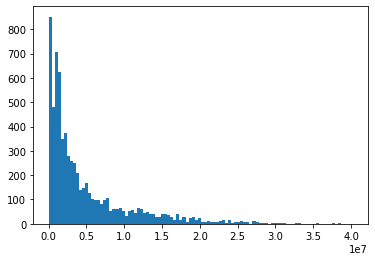

In [64]:
plt.hist(df_final["salary"], bins=100)
plt.show()

### Question 1a

Metric for evaluation: Silhouette Score
    
    Silhouette Coefficient = (x-y)/ max(x,y)
    where x = mean intercluster distance and y = mean intracluster distance

Define cluster sizes

In [65]:
n_clusters = range(2, 22)

Form clusters using salary

In [66]:
df_salary_clusters = df_final.loc[:, "salary"].to_frame()
df_salary_Kmeans = df_final.loc[:, "salary"].to_frame()

Fit Kmeans to salary to identify optimal clusters

In [502]:
for n_cluster in n_clusters:
    kmeans = KMeans(n_clusters=n_cluster, random_state=0, max_iter=1000).fit(df_salary_Kmeans)
    df_salary_clusters["cluster_{}".format(n_cluster)] = kmeans.labels_

Evaluate similarity of salary clusters

In [503]:
all_salary_scores = []

for n_cluster in n_clusters:
    score = silhouette_score(df_salary_clusters["salary"].to_frame(), df_salary_clusters["cluster_{}".format(n_cluster)])
    all_salary_scores.append(score)

In [504]:
all_salary_scores

[0.7381452959957626,
 0.6796920733722058,
 0.6451338085416466,
 0.6116846185878068,
 0.6008688107713919,
 0.5930630154316684,
 0.5774114546718456,
 0.5716190350626539,
 0.5518372485074354,
 0.5467786641840835,
 0.5461950364100183,
 0.5455401195512698,
 0.569054119038075,
 0.5716171020834102,
 0.5693514103790446,
 0.5683562861276443,
 0.5739582606083161,
 0.5793098056013686,
 0.581081546073071,
 0.5779431290474045]

Get predictors

In [67]:
df_Kmeans = df_final.drop(columns=["salary"])
df_Kmeans_clusters = df_final.drop(columns=["salary"])
df_Kmeans_cols = df_Kmeans.columns

Normalize predictors

In [68]:
scaler = StandardScaler()
df_Kmeans = pd.DataFrame(scaler.fit_transform(df_Kmeans), columns=df_Kmeans_cols)

Random selection of predictors

In [69]:
def _generate_random_predictors(df_Kmeans):
    size_pct = float(np.random.randint(low=0, high=100))/100
    size = max(int(df_Kmeans.shape[1] * size_pct), 1)
    features = np.random.choice(list(df_Kmeans.columns), size=size, replace=False)
    
    return df_Kmeans.loc[:, features]

Define number of random selections of predictors

In [70]:
n_feature_selection = range(50)

Fit Kmeans

In [517]:
all_feature_clusters = []

for i in n_feature_selection:
    df_features = _generate_random_predictors(df_Kmeans=df_Kmeans)
    
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster, random_state=0, max_iter=1000).fit(df_features)
        
        feature_cluster = (list(df_features.columns), kmeans.labels_, n_cluster)
        all_feature_clusters.append(feature_cluster)

Evaluate similarity of players in clusters

In [518]:
player_similarity = []
salary_similarity = []

for feature_cluster in all_feature_clusters:
    df_subset = df_Kmeans.loc[:, feature_cluster[0]]
    player_score = silhouette_score(df_subset, feature_cluster[1])
    salary_score = silhouette_score(df_salary_Kmeans, feature_cluster[1])
    
    player_similarity.append([feature_cluster[0], feature_cluster[2], player_score])
    salary_similarity.append([feature_cluster[0], feature_cluster[2], salary_score])

Identify best combination

In [519]:
player_similarity = sorted(player_similarity, key=lambda x: x[2], reverse=True)
salary_similarity = sorted(salary_similarity, key=lambda x: x[2], reverse=True)

In [523]:
optimal_columns = salary_similarity[0][0]
optimal_k = salary_similarity[0][1]

### Question 1b

In [524]:
print("Attributes of players used: {}".format(optimal_columns))

Attributes of players used: ['efg%', 'SF-PF', 'SF-C', 'team_pf', '2009', 'team_3p%', 'SF', 'team_3pa', 'SG', 'blk', 'SF-SG', 'ast', 'fga', 'team_drb', 'PF-C', 'gs']


### Question 1c

In [525]:
print("Number of clusters chosen: 2. Silhouette scores for k={} is the highest across all experiments.".format(
      optimal_k))

Number of clusters chosen: 2. Silhouette scores for k=2 is the highest across all experiments.


### Question 1d

Try different random states

In [570]:
df_features = df_Kmeans.loc[:, optimal_columns]

def random_initializations(df_features, k, tries):
    clusters = []
    
    for i in range(tries):
        random_state = np.random.randint(low=0, high=9999)
        kmeans = KMeans(n_clusters=k, random_state=random_state, max_iter=1000).fit(df_features)
        kmeans = pd.Series(kmeans.labels_)
        clusters.append(kmeans)

    clusters = pd.concat(clusters, axis=1)
    return clusters
    
cluster_labels = random_initializations(df_features=df_features, k=optimal_k, tries=4)

In [571]:
cluster_labels

,0,1,2,3
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
6925,0,0,1,0
6926,0,0,1,0
6927,0,0,1,0
6928,0,0,1,0


In [573]:
print("We get same results with different initialization of cluster centers using k={} and features={}".format(
      optimal_k, optimal_columns))

We get same results with different initialization of cluster centers using k=2 and features=['efg%', 'SF-PF', 'SF-C', 'team_pf', '2009', 'team_3p%', 'SF', 'team_3pa', 'SG', 'blk', 'SF-SG', 'ast', 'fga', 'team_drb', 'PF-C', 'gs']


### Question 1e

Interpret clusters

In [574]:
print(optimal_columns)

['efg%', 'SF-PF', 'SF-C', 'team_pf', '2009', 'team_3p%', 'SF', 'team_3pa', 'SG', 'blk', 'SF-SG', 'ast', 'fga', 'team_drb', 'PF-C', 'gs']


### Question 2a

Select most current season

In [609]:
df_current_ols = df_final.loc[df_final[str(MOST_CURRENT_SEASON)]==1, :]
ols_y = df_current_ols["salary"]
ols_X = df_current_ols.drop(columns=["salary", "2019"])

Stepwise regression

In [71]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = excluded[new_pval.argmin()]
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [611]:
stepwise_results = stepwise_selection(X=ols_X, y=ols_y) 

Add  pts                            with p-value 1.72177e-67
Add  experience_YTD                 with p-value 8.26602e-25
Add  team_count                     with p-value 8.95348e-10
Add  team_pts                       with p-value 5.89269e-05
Add  drb                            with p-value 6.60187e-05
Add  efg%                           with p-value 9.27227e-05
Add  ast                            with p-value 0.00330065
Add  blk                            with p-value 0.000617257
Add  pf                             with p-value 0.00125441
Add  g                              with p-value 0.00377396


In [612]:
print("Independent variables: {}".format(stepwise_results))

Independent variables: ['pts', 'experience_YTD', 'team_count', 'team_pts', 'drb', 'efg%', 'ast', 'blk', 'pf', 'g']


### Question 2b

Reason for model

In [613]:
print("Stepwise regression was carried out and the selected variables are significant in improving the prediction of salary.")

Stepwise regression was carried out and the selected variables are significant in improving the prediction of salary.


### Question 2c

Selected OLS model

In [616]:
final_ols_X = df_current_ols.loc[:, stepwise_results]
model = sm.OLS(ols_y, sm.add_constant(pd.DataFrame(final_ols_X))).fit()

Get coefficients

In [620]:
ols_coefficients = model.params
print(ols_coefficients)

const             3.024189e+07
pts               5.491655e+05
experience_YTD    7.231639e+05
team_count       -3.792630e+06
team_pts         -2.204832e+05
drb               7.671680e+05
efg%             -7.085619e+06
ast               8.133095e+05
blk               3.140358e+06
pf               -1.356711e+06
g                -3.552023e+04
dtype: float64


 <Insert interpretation>

Interpret results

In [621]:
print("INSERT INTERPRETATION....")

INSERT INTERPRETATION....


### Question 2d

Statistically significant variables

In [624]:
sig_val = 0.05
print("Statistically significant variables:")
model.pvalues[model.pvalues < sig_val]

Statistically significant variables:


const             8.564896e-06
pts               3.107996e-15
experience_YTD    1.363409e-31
team_count        6.013799e-09
team_pts          2.884903e-04
drb               5.133623e-04
efg%              4.001563e-03
ast               7.289583e-05
blk               5.212981e-05
pf                1.417350e-03
g                 3.773961e-03
dtype: float64

### Question 2e

Analysis

In [625]:
print("INSERT ANALYSIS....")

INSERT ANALYSIS....


### Question 2f

Believe in results

In [626]:
print("INSERT CONCLUSION....")

INSERT CONCLUSION....


### Question 3a

Residual vs Fitted plot

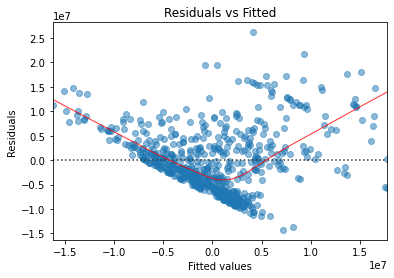

In [645]:
ax = plt.figure()
ax.axes[0] = sns.residplot(y=model.fittedvalues, x=model.resid, 
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

ax.axes[0].set_title('Residuals vs Fitted')
ax.axes[0].set_xlabel('Fitted values')
ax.axes[0].set_ylabel('Residuals');

Estimation for coefficients

In [654]:
print("From the residuals vs fitted plot, most the coefficients tend to be underestimated for larger "
      "absolute value of fitted values but overestimated for smaller absolute value of fitted values. Also, "
      "it is noted that the shape of the residual plot implies a non-linear relationship.")

From the residuals vs fitted plot, most the coefficients tend to be underestimated for larger absolute value of fitted values but overestimated for smaller absolute value of fitted values. Also, it is noted that the shape of the residual plot implies a non-linear relationship.


### Question 3b

Heteroskedasticity

In [660]:
# Breusch Pagan test
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
bptest = sms.het_breuschpagan(model.resid, model.model.exog)
dict(zip(name, bptest))

{'Lagrange multiplier statistic': 150.26556217678808,
 'p-value': 3.28685551447711e-27,
 'f-value': 19.453316004573683,
 'f p-value': 2.7784221291679433e-31}

In [662]:
print("From the residuals vs fitted plot, the spread of the residuals is not constant, hence heteroskedasticity "
      "is present. In addition, from the results of the Breusch-Pagan test, the p-value is < 0.05 and hence, "
      "we reject the null hypothesis of homoskedasticity. To fix this, we will use the White-Huber standard errors.")

From the residuals vs fitted plot, the spread of the residuals is not constant, hence heteroskedasticity is present. In addition, from the results of the Breusch-Pagan test, the p-value is < 0.05 and hence, we reject the null hypothesis of homoskedasticity. To fix this, we will use the White-Huber standard errors.


New OLS using White-Huber standard error

In [695]:
model_wh = sm.OLS(ols_y, sm.add_constant(pd.DataFrame(final_ols_X))).fit(cov_type="HC0")

### Question 3c

Multicollinearity (Via Correlation Matrix)

In [698]:
final_ols_X.corr()

,pts,experience_YTD,team_count,team_pts,drb,efg%,ast,blk,pf,g
pts,1.000000,0.130580,-0.259385,0.040007,0.644239,0.255068,0.730637,0.301547,0.544584,0.453923
experience_YTD,0.130580,1.000000,0.213952,0.151096,0.152065,0.076451,0.166626,0.049126,0.069178,0.049003
team_count,-0.259385,0.213952,1.000000,0.072816,-0.244727,-0.049245,-0.216521,-0.147979,-0.185828,-0.391453
team_pts,0.040007,0.151096,0.072816,1.000000,0.017601,0.111327,-0.003679,0.034808,-0.009857,0.061377
drb,0.644239,0.152065,-0.244727,0.017601,1.000000,0.293133,0.390905,0.632185,0.689827,0.394970
efg%,0.255068,0.076451,-0.049245,0.111327,0.293133,1.000000,0.069482,0.306110,0.326923,0.290667
ast,0.730637,0.166626,-0.216521,-0.003679,0.390905,0.069482,1.000000,0.039374,0.330412,0.355573
blk,0.301547,0.049126,-0.147979,0.034808,0.632185,0.306110,0.039374,1.000000,0.561337,0.211655
pf,0.544584,0.069178,-0.185828,-0.009857,0.689827,0.326923,0.330412,0.561337,1.000000,0.328644
g,0.453923,0.049003,-0.391453,0.061377,0.394970,0.290667,0.355573,0.211655,0.328644,1.000000


### Question 3d

In [699]:
print("From the correlation matrix, we can see that 'pf', 'blk' and 'drb' has fairly high correlation which might "
      "result in multicollinearity. As such, we can use PCA to fix this as PCA projects the data into lower dimensional "
      "space while preserving the variation by using orthogonal linear combinations of the original data. However, "
      "we might lose interpretability after the use of PCA.")

From the correlation matrix, we can see that 'pf', 'blk' and 'drb' has fairly high correlation which might result in multicollinearity. As such, we can use PCA to fix this as PCA projects the data into lower dimensional space while preserving the variation by using orthogonal linear combinations of the original data. However, we might lose interpretability after the use of PCA.


### Question 4a

Get panel data

In [95]:
df_panel = df.copy(deep=True)
#df_panel["pos"] = df_panel[pos_dummies.columns].idxmax(axis=1)
df_panel["season_year"] = df_panel[season_year_dummies.columns].idxmax(axis=1).astype(int)
df_panel = df_panel.drop(columns=list(season_year_dummies.columns))

Key columns

In [96]:
panel_key_cols = list(df_panel.columns)
panel_key_cols.remove("age")
panel_key_cols.remove("total_salary")
panel_key_cols.remove("player")
panel_key_cols.remove("season")
panel_key_cols.remove("pos")
panel_key_cols.remove("start_year")
panel_key_cols.remove("full_team_name")
panel_key_cols.remove("latest_year")
panel_key_cols.remove("team_location")
panel_key_cols.remove("experience")
panel_key_cols.remove("team_total_seasons")
panel_key_cols.remove("team_championships")
panel_key_cols.remove("team_playoff_appearances")
panel_key_cols.remove("team_g")
panel_key_cols.remove("team_mp")
panel_key_cols.remove("team_record")
panel_key_cols.remove("team_fg")
panel_key_cols.remove("tm")

In [97]:
df_panel = df_panel.loc[:, panel_key_cols]

Set index

In [98]:
season_year = pd.Categorical(df_panel["season_year"])
df_panel = df_panel.set_index(["team_name", "season_year"])
df_panel["season_year"] = season_year

Get exogeneous variables

In [101]:
exog_var = list(df_panel.columns)
exog_var.remove("season_year")
exog_var.remove("salary")
exog_var.remove("SG-PG")

In [103]:
exog = df_panel[exog_var]#.astype(float)
exog = sm.add_constant(exog)

Get endogeneous variable

In [104]:
endog = df_panel["salary"]

Fixed effect model

In [105]:
model_fe = PanelOLS(endog, exog, entity_effects = True)
fe_res = model_fe.fit()
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 salary   R-squared:                        0.5451
Estimator:                   PanelOLS   R-squared (Between):              0.2689
No. Observations:                6930   R-squared (Within):               0.5451
Date:                Sat, Mar 06 2021   R-squared (Overall):              0.5435
Time:                        19:25:46   Log-likelihood                -1.151e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      127.99
Entities:                          30   P-value                           0.0000
Avg Obs:                       231.00   Distribution:                 F(64,6836)
Min Obs:                       186.00                                           
Max Obs:                       282.00   F-statistic (robust):             127.99
                            

Random effect model

In [106]:
model_re = RandomEffects(endog, exog)
re_res = model_re.fit()
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                 salary   R-squared:                        0.5443
Estimator:              RandomEffects   R-squared (Between):              0.4822
No. Observations:                6930   R-squared (Within):               0.5445
Date:                Sat, Mar 06 2021   R-squared (Overall):              0.5443
Time:                        19:26:22   Log-likelihood                -1.152e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      128.13
Entities:                          30   P-value                           0.0000
Avg Obs:                       231.00   Distribution:                 F(64,6865)
Min Obs:                       186.00                                           
Max Obs:                       282.00   F-statistic (robust):             128.13
                            

Get significant variables

In [115]:
# Fixed effect
fe_pvalues = fe_res.pvalues
fe_sig_cols = list(fe_pvalues[fe_pvalues<sig_val].index)
print("Significant variables (FE): {}".format(fe_sig_cols))

# Random effect
re_pvalues = re_res.pvalues
re_sig_cols = list(re_pvalues[re_pvalues<sig_val].index)
print("Significant variables (RE): {}".format(re_sig_cols))

Significant variables (FE): ['g', 'gs', 'mp', 'fga', 'fg%', '3p%', '2pa', '2p%', 'efg%', 'ast', 'blk', 'pf', 'height', 'weight', 'experience_YTD', 'team_2pa', 'team_2p%', 'team_stl', 'team_count', 'age_YTD']
Significant variables (RE): ['g', 'gs', 'mp', 'fga', 'fg%', '3p%', '2pa', '2p%', 'efg%', 'ast', 'blk', 'pf', 'height', 'weight', 'experience_YTD', 'team_fga', 'team_3pa', 'team_2pa', 'team_2p%', 'team_ast', 'team_stl', 'team_count', 'age_YTD']


### Question 4b

Time-invariant predictors

In [123]:
exog.columns

Index(['const', 'g', 'gs', 'mp', 'fg', 'fga', 'fg%', '3p', '3pa', '3p%', '2p',
       '2pa', '2p%', 'efg%', 'ft', 'fta', 'ft%', 'orb', 'drb', 'trb', 'ast',
       'stl', 'blk', 'tov', 'pf', 'pts', 'height', 'weight', 'experience_YTD',
       'team_fga', 'team_fg%', 'team_3p', 'team_3pa', 'team_3p%', 'team_2p',
       'team_2pa', 'team_2p%', 'team_ft', 'team_fta', 'team_ft%', 'team_orb',
       'team_drb', 'team_trb', 'team_ast', 'team_stl', 'team_blk', 'team_tov',
       'team_pf', 'team_pts', 'team_count', 'C', 'C-PF', 'PF', 'PF-C', 'PF-SF',
       'PG', 'PG-SG', 'SF', 'SF-C', 'SF-PF', 'SF-SG', 'SG', 'SG-PF', 'SG-SF',
       'age_YTD'],
      dtype='object')

In [124]:
print("Time-invariant variables: {}".format(["height", "weight"]))

Time-invariant variables: ['height', 'weight']


In [125]:
print("No. No fixed effect alpha i is correlated with the predictors.")

No. No fixed effect alpha i is correlated with the predictors.


### Question 4c

Hausman test

In [121]:
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, np.linalg.inv(v_b - v_B).dot(b - B)) 

    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(fe_res, re_res) 
print("chi-Squared: {}".format(str(hausman_results[0])))
print("degrees of freedom: {}".format(str(hausman_results[1])))
print("p-Value: {}".format(str(hausman_results[2])))

chi-Squared: 76.72161367111767
degrees of freedom: 65
p-Value: 0.15157015870262835


In [122]:
print("Since p-value of Hausman test > 0.05, we accept the null hypothesis of using RandomEffect model.")

Since p-value of Hausman test > 0.05, we accept the null hypothesis of using RandomEffect model.


### Question 4d

Recommendation

In [126]:
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                 salary   R-squared:                        0.5443
Estimator:              RandomEffects   R-squared (Between):              0.4822
No. Observations:                6930   R-squared (Within):               0.5445
Date:                Sat, Mar 06 2021   R-squared (Overall):              0.5443
Time:                        19:26:22   Log-likelihood                -1.152e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      128.13
Entities:                          30   P-value                           0.0000
Avg Obs:                       231.00   Distribution:                 F(64,6865)
Min Obs:                       186.00                                           
Max Obs:                       282.00   F-statistic (robust):             128.13
                            

Get coefficients of significant variables

In [142]:
re_coeff = re_res.params[re_pvalues<sig_val]
re_coeff = re_coeff.to_frame().reset_index(drop=False)
re_coeff.columns = ["predictor", "coefficient"]

In [146]:
for i, row in re_coeff.iterrows():
    predictor = row["predictor"]
    coefficient = row["coefficient"]
    
    print("On average, for every unit increase in {}, increase the players pay by ${}".format(
          predictor, round(coefficient, 2)))

On average, for every unit increase in g, increase the players pay by -20764.52
On average, for every unit increase in gs, increase the players pay by 25389.58
On average, for every unit increase in mp, increase the players pay by -99572.41
On average, for every unit increase in fga, increase the players pay by 2326865.92
On average, for every unit increase in fg%, increase the players pay by 6731702.85
On average, for every unit increase in 3p%, increase the players pay by -1054832.07
On average, for every unit increase in 2pa, increase the players pay by -2729691.52
On average, for every unit increase in 2p%, increase the players pay by -2399244.14
On average, for every unit increase in efg%, increase the players pay by -5335609.54
On average, for every unit increase in ast, increase the players pay by 531267.82
On average, for every unit increase in blk, increase the players pay by 676476.17
On average, for every unit increase in pf, increase the players pay by -808412.19
On average

### Question 5a

### Question 5b

In [147]:
print("We can include coorperation amongst members by adding the average statistics of the players in the team "
      "and statistics of assists as exogeneous variables.")

We can include coorperation amongst members by adding the average statistics of the players in the team and statistics of assists as exogeneous variables.


# KIV

Get non-primary key columns

In [ ]:
# Get columns related to player statistics
player_stats_columns = list(df_player_stats.columns)
player_stats_columns.remove("player")
player_stats_columns.remove("season")

# Get columns related to player salary
salary_columns = list(df_salary.columns)
salary_columns.remove("player")
salary_columns.remove("season")

# Get columns related to team statistics
team_stats_columns = list(df_team_stats.columns)
team_stats_columns.remove("team_name")
team_stats_columns.remove("season")

# Get columns related to team info
team_info_columns = list(df_team_info.columns)
team_info_columns.remove("team_name")
team_info_columns.remove("full_team_name")

### Combined Player Info

In [ ]:
import glob

In [ ]:
player_info = glob.glob(os.path.join(DATA_FOLDER, "player_active_info", "*.csv"))
player_inact_info = glob.glob(os.path.join(DATA_FOLDER, "player_inactive_info", "*.csv"))

In [ ]:
full_df = []

for info in player_info:
    df = pd.read_csv(info)
    full_df.append(df)
    
for info in player_inact_info:
    df = pd.read_csv(info)
    full_df.append(df)
    
full_df = pd.concat(full_df)

In [ ]:
full_df = full_df.drop(columns=["Unnamed: 0"])
full_df = full_df.drop_duplicates(keep="first").reset_index(drop=True)

In [ ]:
pickle.dump(full_df, open(os.path.join(DATA_FOLDER, "player_info.pkl"), "wb"))

Aggregate teams and positions

In [213]:
group_cols = ["g", "gs", "mp", "fg", "fga", "fg%", "3p", "3pa", "3p%", "2p", "2pa", "2p%",
              "efg%", "ft", "fta", "ft%", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pf", "pts",
              "season_year", "height", "weight", "total_salary", "experience_YTD", "team_count", "age_YTD"]
agg_cols = {col: "sum" for col in key_cols if col not in group_cols}

df_final = df.groupby(group_cols).agg(agg_cols).reset_index(drop=False)

One hot encode "team_name"

In [274]:
team_name_dummies = pd.get_dummies(df["team_name"])
df = df.merge(team_name_dummies,
              how="inner",
              left_index=True,
              right_index=True).reset_index(drop=True)